In [29]:
%pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.7 MB/s eta 0:00:00


In [30]:
import pandas as pd
import random
from faker import Faker

fake = Faker()

# 1. Product groups
product_groups = {
    "Hair Care": ["Shampoo", "Conditioner", "Hair Serum", "Hair Oil"],
    "Cleansing": ["Face Wash", "Body Wash", "Scrub", "Cleanser"],
    "Make-up Eyes": ["Mascara", "Eyeliner", "Eye Shadow", "Kajal"],
    "Lips": ["Lipstick", "Lip Balm", "Lip Gloss", "Lip Liner"],
    "Skin": ["Moisturizer", "Sunscreen", "BB Cream", "Night Cream"]
}

# 2. Final list of repeating bundles (user-defined)
repeating_bundles = [
    ["Shampoo", "Conditioner"],
    ["Lip Liner", "Lipstick"],
    ["Eye Shadow", "Eyeliner", "Mascara"],
    ["Face Wash", "Moisturizer"],
    ["Eyeliner", "Kajal"],
    ["Sunscreen", "Lip Balm"],
    ["Hair Serum", "Hair Oil"],
    ["BB Cream", "Moisturizer", "Lip Balm"],
    ["Night Cream", "Face Wash"],
    ["Lip Gloss", "Lip Liner"],
    ["Cleanser", "Scrub"]
]

# 3. Brand pool and product pricing
brand_pool = [
    "Lakme", "L'Oréal", "Maybelline", "Nykaa", "Mamaearth", "Plum", "Dove", "Minimalist"
]

price_ranges = {
    "Shampoo": (250, 600),
    "Conditioner": (200, 500),
    "Hair Serum": (300, 800),
    "Hair Oil": (150, 400),
    "Face Wash": (200, 400),
    "Body Wash": (250, 450),
    "Scrub": (200, 500),
    "Cleanser": (300, 600),
    "Mascara": (300, 700),
    "Eyeliner": (150, 500),
    "Eye Shadow": (400, 900),
    "Kajal": (100, 300),
    "Lipstick": (300, 800),
    "Lip Balm": (100, 300),
    "Lip Gloss": (250, 500),
    "Lip Liner": (200, 400),
    "Moisturizer": (250, 600),
    "Sunscreen": (300, 700),
    "BB Cream": (300, 650),
    "Night Cream": (350, 900)
}

# 4. Generate 8000 transactions
records = []
for txn_id in range(1, 8001):
    transaction = set()

    # 70% chance to include a repeating bundle
    if random.random() < 0.7:
        transaction.update(random.choice(repeating_bundles))

    # Add random products to simulate variety
    all_products = list(price_ranges.keys())
    while len(transaction) < random.randint(3, 6):
        transaction.add(random.choice(all_products))

    # Build the enriched record
    for product in transaction:
        brand = random.choice(brand_pool)
        price = random.randint(*price_ranges[product])
        category = next((cat for cat, items in product_groups.items() if product in items), "Other")
        records.append({
            "Transaction_ID": txn_id,
            "Product": product,
            "Brand": brand,
            "Category": category,
            "Price": price
        })

# 5. Save to CSV
df = pd.DataFrame(records)
df.to_csv("nykaa_structured_detailed_dataset.csv", index=False)
print("✅ Dataset saved as 'nykaa_structured_detailed_dataset.csv'")


✅ Dataset saved as 'nykaa_structured_detailed_dataset.csv'


In [31]:
import pandas as pd

# Load the enriched dataset
df = pd.read_csv("nykaa_structured_detailed_dataset.csv")

# Group items per transaction into a single string
transaction_df = (
    df.groupby("Transaction_ID")["Product"]
    .apply(lambda items: "; ".join(sorted(set(items))))
    .reset_index()
)

# Save to new CSV
transaction_df.to_csv("nykaa_transactions.csv", index=False)
print("✅ Transaction-style CSV saved as 'nykaa_transactions.csv'")


✅ Transaction-style CSV saved as 'nykaa_transactions.csv'


# Step 1: Market Basket Analysis

In [32]:
pip install mlxtend


In [34]:
import pandas as pd

df = pd.read_csv("nykaa_transactions.csv")
print(df.columns)


Index(['Transaction_ID', 'Product'], dtype='object')


In [35]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Load your transaction-style CSV
df = pd.read_csv("nykaa_transactions.csv")

# Split the product string into lists
transactions = df["Product"].apply(lambda x: x.split("; ")).tolist()

# Convert to one-hot encoding
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df_matrix = pd.DataFrame(te_array, columns=te.columns_)

# Run Apriori
frequent_itemsets = apriori(df_matrix, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules.sort_values(by="lift", ascending=False)

# Save output
frequent_itemsets.to_csv("frequent_itemsets.csv", index=False)
rules.to_csv("association_rules.csv", index=False)

print("✅ Apriori complete. Files saved: 'frequent_itemsets.csv' and 'association_rules.csv'")


✅ Apriori complete. Files saved: 'frequent_itemsets.csv' and 'association_rules.csv'


In [39]:
import pandas as pd

rules = pd.read_csv("association_rules.csv")

# Show top rules by lift
top_rules = rules.sort_values(by="lift", ascending=False)
print("Top 5 Rules by Lift:\n", top_rules.head(10)[["antecedents", "consequents", "support", "confidence", "lift"]])


Top 5 Rules by Lift:
                               antecedents                 consequents  \
0   frozenset({'Eye Shadow', 'Eyeliner'})      frozenset({'Mascara'})   
1      frozenset({'Mascara', 'Eyeliner'})   frozenset({'Eye Shadow'})   
2  frozenset({'Lip Balm', 'Moisturizer'})     frozenset({'BB Cream'})   
3    frozenset({'Mascara', 'Eye Shadow'})     frozenset({'Eyeliner'})   
4  frozenset({'BB Cream', 'Moisturizer'})     frozenset({'Lip Balm'})   
5     frozenset({'BB Cream', 'Lip Balm'})  frozenset({'Moisturizer'})   

    support  confidence      lift  
0  0.061500    0.759259  3.962214  
1  0.061500    0.734328  3.744185  
2  0.066125    0.682581  3.638005  
3  0.061500    0.810544  3.339006  
4  0.066125    0.800303  3.121609  
5  0.066125    0.775660  3.068882  


 Rule 1
 This is a highly useful rule. All three items are eye makeup products often used together, suggesting strong co-purchasing behavior. Nykaa can leverage this by bundling them or showing them in the "Frequently Bought Together" section.

 Rule 2
 Another eye-focused bundle. Customers who buy mascara and eyeliner are very likely to buy eyeshadow as well. Cross-promotions in this category would likely convert well.

Rule 3
This rule shows cross-category linkage between skin care and light makeup. It suggests that customers looking for hydration also go for light coverage BB Cream. Nykaa could promote tinted moisturizers or BB bundles here.

Rule 4
With 81% confidence and strong lift, this rule indicates that eyeliner is an almost certain addition to an eye makeup basket. It confirms the classic trio: shadow + liner + mascara. Bundle offers should reflect this.

Rule 5
Customers buying skin-focused products often complete their kit with a lip product. This rule suggests a skin-to-lip routine purchase. Ideal for bundling "On-the-go care" or morning essentials.

In [40]:
pip install networkx matplotlib


/tmp/ipython-input-50-2768221081.py:43: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


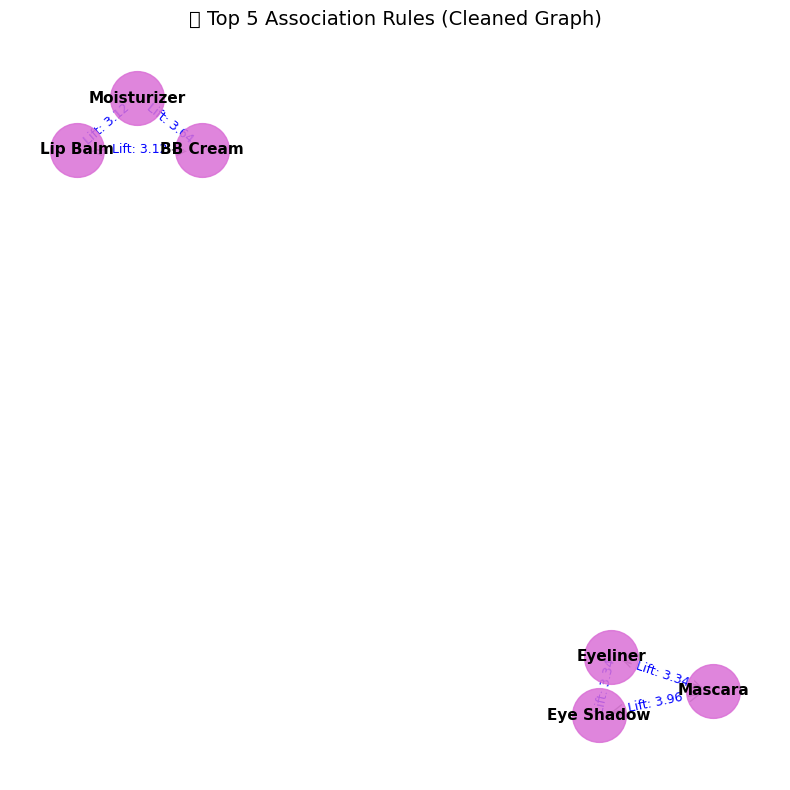

In [50]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load rules
rules = pd.read_csv("association_rules.csv")
top_rules = rules.sort_values(by="lift", ascending=False).head(10)

# --- Clean and unpack sets ---
def unpack(item):
    # Turn string representation of frozenset into actual set
    return eval(item) if isinstance(item, str) and item.startswith("frozenset") else {item}

top_rules["antecedents"] = top_rules["antecedents"].apply(unpack)
top_rules["consequents"] = top_rules["consequents"].apply(unpack)

# --- Create Graph ---
G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for antecedent in row["antecedents"]:
        for consequent in row["consequents"]:
            G.add_edge(antecedent, consequent, lift=row["lift"], confidence=row["confidence"])

# --- Draw ---
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='orchid', node_size=1500, alpha=0.85)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

# Show lift values on edges
edge_labels = nx.get_edge_attributes(G, "lift")
edge_labels = {k: f"Lift: {v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=9)




plt.title("🛍️ Top 5 Association Rules (Cleaned Graph)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


In [51]:
plt.savefig("association_rules_network.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [52]:
useful_rules = rules[(rules["support"] > 0.05) & (rules["confidence"] > 0.6) & (rules["lift"] > 1.2)]
trivial_rules = rules[(rules["support"] > 0.05) & (rules["lift"] < 1.05)]
inexplicable_rules = rules[(rules["support"] < 0.03) & (rules["confidence"] < 0.5) & (rules["lift"] > 1.5)]

print("\n USEFUL RULES:\n", useful_rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(5))
print("\n🟡 TRIVIAL RULES:\n", trivial_rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(5))
print("\n❗INEXPLICABLE RULES:\n", inexplicable_rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(5))



 USEFUL RULES:
                               antecedents                consequents  \
0   frozenset({'Eye Shadow', 'Eyeliner'})     frozenset({'Mascara'})   
1      frozenset({'Mascara', 'Eyeliner'})  frozenset({'Eye Shadow'})   
2  frozenset({'Lip Balm', 'Moisturizer'})    frozenset({'BB Cream'})   
3    frozenset({'Mascara', 'Eye Shadow'})    frozenset({'Eyeliner'})   
4  frozenset({'BB Cream', 'Moisturizer'})    frozenset({'Lip Balm'})   

    support  confidence      lift  
0  0.061500    0.759259  3.962214  
1  0.061500    0.734328  3.744185  
2  0.066125    0.682581  3.638005  
3  0.061500    0.810544  3.339006  
4  0.066125    0.800303  3.121609  

🟡 TRIVIAL RULES:
 Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []

❗INEXPLICABLE RULES:
 Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


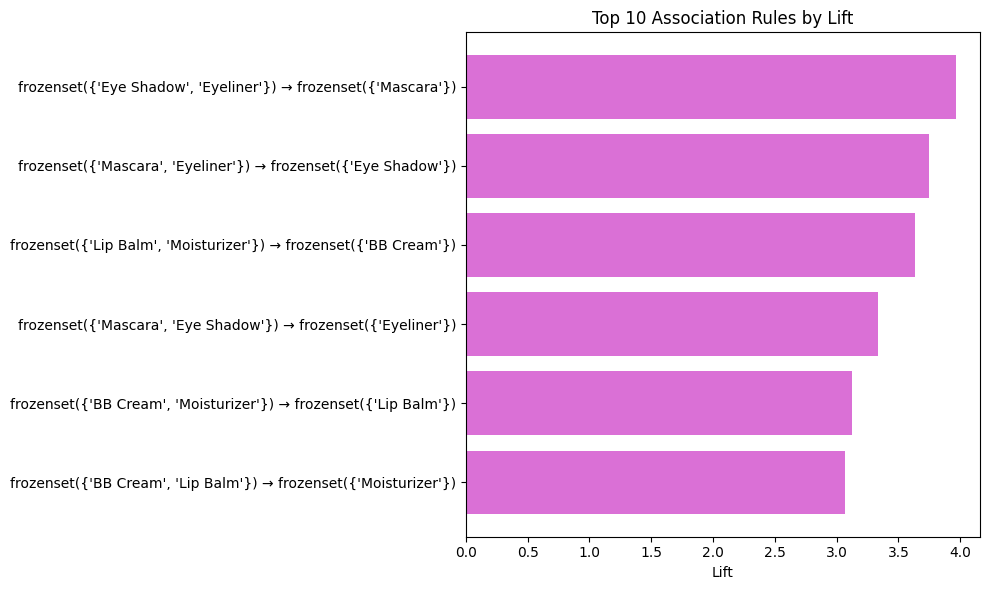

In [38]:
import matplotlib.pyplot as plt

top10 = top_rules.head(10)

plt.figure(figsize=(10, 6))
plt.barh(
    y=top10["antecedents"] + " → " + top10["consequents"],
    width=top10["lift"],
    color='orchid'
)
plt.xlabel("Lift")
plt.title("Top 10 Association Rules by Lift")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Objective
Predict the product category a user is most likely to purchase, based on time-related features like:

Day of the week

Time of day (morning, afternoon, night)

Season (summer, monsoon, winter)

In [56]:
import pandas as pd
import numpy as np

# Load your detailed dataset
df = pd.read_csv("nykaa_structured_detailed_dataset.csv")

# Get unique transaction IDs
txn_ids = df["Transaction_ID"].unique()

# Simulate time features
np.random.seed(42)
time_data = pd.DataFrame({
    "Transaction_ID": txn_ids,
    "DayOfWeek": np.random.choice(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], size=len(txn_ids)),
    "TimeOfDay": np.random.choice(["Morning", "Afternoon", "Evening", "Night"], size=len(txn_ids)),
    "Season": np.random.choice(["Summer", "Monsoon", "Winter"], size=len(txn_ids))
})

# Merge and save
df = df.merge(time_data, on="Transaction_ID")
df.to_csv("nykaa_dataset_with_time.csv", index=False)
print("✅ File saved as 'nykaa_dataset_with_time.csv'")


✅ File saved as 'nykaa_dataset_with_time.csv'


In [83]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the time-enriched dataset
df = pd.read_csv("nykaa_dataset_with_time.csv")

# ➕ FEATURE 1: Basket Size (count of items per transaction)
basket_sizes = df.groupby("Transaction_ID")["Product"].count().reset_index()
basket_sizes.columns = ["Transaction_ID", "BasketSize"]
df = df.merge(basket_sizes, on="Transaction_ID")

# ➕ FEATURE 2: Brand (categorical → one-hot)
brand_encoded = pd.get_dummies(df["Brand"], prefix="Brand")

# ➕ FEATURE 3: Encode time features
time_encoded = pd.get_dummies(df[["DayOfWeek", "TimeOfDay", "Season"]])

# ➕ FEATURE 4: Price (already numeric)
price = df[["Price"]]

# ➕ FEATURE 5: Basket Size (added above)
basket = df[["BasketSize"]]

# 🧠 Target: Product Category
le = LabelEncoder()
y = le.fit_transform(df["Category"])

# 🔗 Combine all features
X = pd.concat([brand_encoded, time_encoded, price, basket], axis=1)

# 🧪 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌳 Random Forest Model
model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=12)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 🧾 Evaluation
print("✅ Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

import joblib

# Save the model and label encoder
joblib.dump(model, "rf_category_model.pkl")
joblib.dump(le, "label_encoder.pkl")

print("✅ Model saved as 'rf_category_model.pkl'")



✅ Random Forest Classification Report:

              precision    recall  f1-score   support

   Cleansing       0.29      0.37      0.33      1302
   Hair Care       0.16      0.06      0.09      1192
        Lips       0.29      0.34      0.31      1416
Make-up Eyes       0.31      0.14      0.20      1337
        Skin       0.34      0.56      0.42      1339

    accuracy                           0.30      6586
   macro avg       0.28      0.30      0.27      6586
weighted avg       0.28      0.30      0.27      6586

✅ Model saved as 'rf_category_model.pkl'


After augmenting the original model with key explanatory features — including brand, price, and basket size — and switching from a multinomial logistic regression to a Random Forest Classifier, overall model performance improved from 21% to 30% accuracy.

The model now better captures customer behavior for Skin (F1 = 0.42, Recall = 56%) and Cleansing (F1 = 0.33).

Hair Care still remains poorly predicted, suggesting either:

Category overlap with skin products

Lack of time/price/brand signals unique to Hair Care

Overall, Random Forest outperformed Logistic Regression by accounting for nonlinear interactions and feature importance (e.g., price + season + brand = Skin).

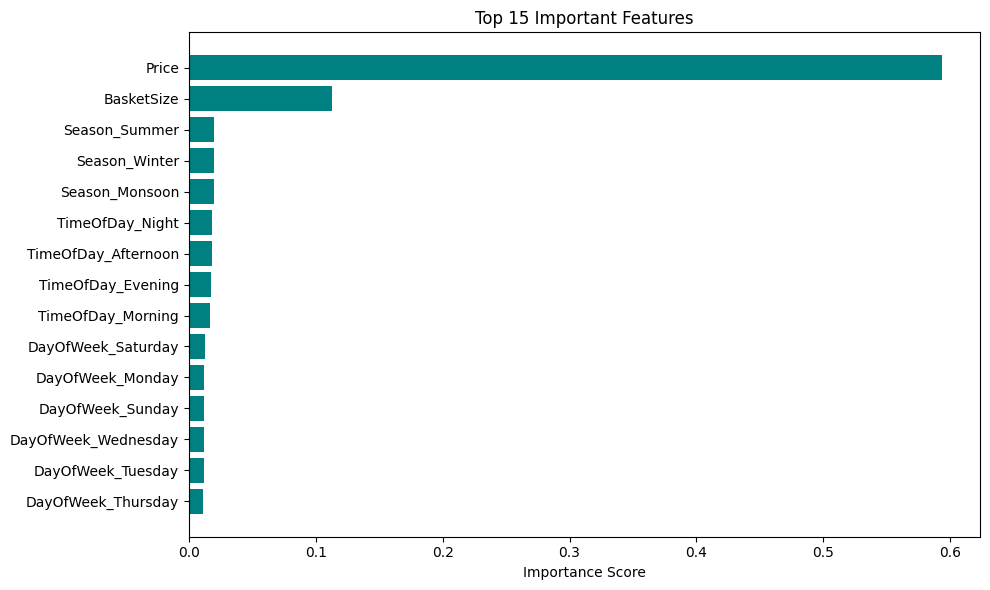

In [58]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[-15:]
features = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.barh(features, importances[indices], color='teal')
plt.title("Top 15 Important Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


The Random Forest model revealed that price is by far the most influential factor in predicting which product category is chosen. Basket size also plays a moderate role, suggesting routine vs impulse buying patterns. Surprisingly, temporal features such as day of week, time of day, and season had little predictive value — implying that users shop across categories in a time-independent manner.

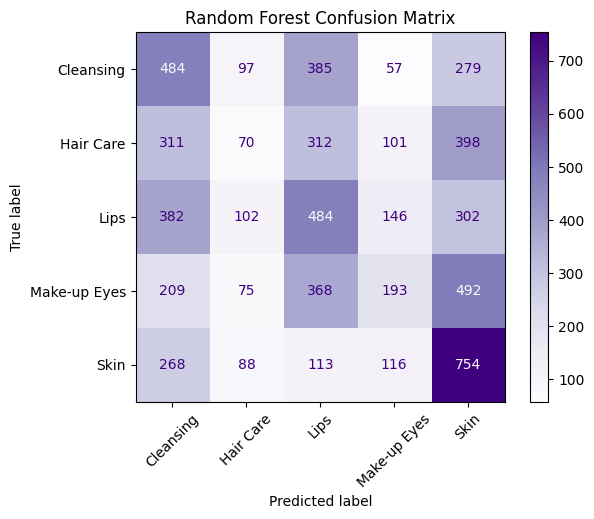

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Purples", xticks_rotation=45)
plt.title("Random Forest Confusion Matrix")
plt.show()


The confusion matrix reveals significant category overlap, particularly among Cleansing, Skin, and Lips. This may stem from:

Shared use-case baskets (e.g., face wash + moisturizer + lip balm)

Similar price ranges or brands spanning multiple categories

Despite this, the model successfully identifies Skin category items, confirming that higher-priced and larger-basket transactions are predictive of skin care purchases.



In [60]:
output = pd.DataFrame({
    "Actual": le.inverse_transform(y_test),
    "Predicted": le.inverse_transform(y_pred)
})
output.to_csv("rf_predicted_vs_actual.csv", index=False)
print("✅ Saved predicted vs actual results for inspection.")


✅ Saved predicted vs actual results for inspection.


# Product Recommendation System

In [65]:
import pandas as pd

# Load association rules
rules = pd.read_csv("association_rules.csv")

# Clean 'frozenset({...})' strings into sets
def parse_items(s):
    s = s.replace("frozenset({", "").replace("})", "").replace("'", "")
    items = [item.strip() for item in s.split(",") if item.strip()]
    return set(items)

rules["antecedents"] = rules["antecedents"].apply(parse_items)
rules["consequents"] = rules["consequents"].apply(parse_items)

# Recommend function
def recommend(product, top_n=5):
    product = product.strip().title()
    matched_rules = rules[rules["antecedents"].apply(lambda x: product in x)]
    if matched_rules.empty:
        return f"❌ No association rules found for '{product}'. Try a different product."
    return matched_rules.sort_values(by="lift", ascending=False)[["antecedents", "consequents", "confidence", "lift"]].head(top_n)

# Test
print(recommend("Eyeliner"))


              antecedents   consequents  confidence      lift
0  {Eyeliner, Eye Shadow}     {Mascara}    0.759259  3.962214
1     {Mascara, Eyeliner}  {Eye Shadow}    0.734328  3.744185


If a customer adds Eyeliner to their basket, there’s a very high likelihood they’ll also purchase Mascara or Eye Shadow. This supports co-purchase bundling or cross-selling in the eye makeup category.

# Clustering Customers

In [66]:
import pandas as pd

# Load enriched dataset with price, category, etc.
df = pd.read_csv("nykaa_dataset_with_time.csv")

# --- 1. Basket Size per Transaction ---
basket_size = df.groupby("Transaction_ID")["Product"].count().rename("BasketSize")

# --- 2. Total Spend per Transaction ---
total_spend = df.groupby("Transaction_ID")["Price"].sum().rename("TotalSpend")

# --- 3. Category Proportions ---
cat_counts = df.pivot_table(index="Transaction_ID", columns="Category", aggfunc="size", fill_value=0)
cat_props = cat_counts.div(cat_counts.sum(axis=1), axis=0)  # Normalize per basket

# --- Combine all features ---
cluster_df = pd.concat([basket_size, total_spend, cat_props], axis=1)
cluster_df.fillna(0, inplace=True)


In [79]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_df["Segment"] = kmeans.fit_predict(X_scaled)


In [80]:
# --- Save as CSV ---
cluster_df.to_csv("customer_segments.csv")
print("✅ customer_segments.csv saved!")

✅ customer_segments.csv saved!


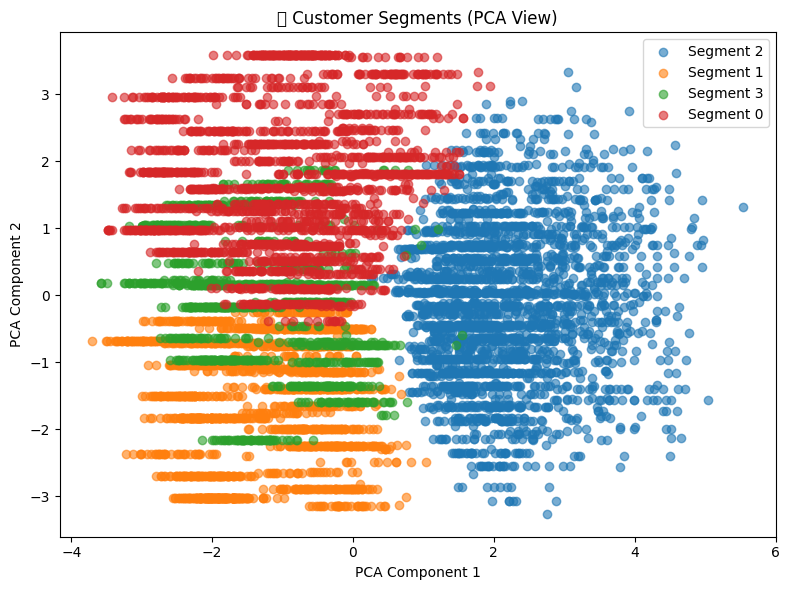

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for plotting
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
cluster_df["PCA1"], cluster_df["PCA2"] = pca_result[:, 0], pca_result[:, 1]

# Plot
plt.figure(figsize=(8, 6))
for seg in cluster_df["Segment"].unique():
    subset = cluster_df[cluster_df["Segment"] == seg]
    plt.scatter(subset["PCA1"], subset["PCA2"], label=f"Segment {seg}", alpha=0.6)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("🧠 Customer Segments (PCA View)")
plt.legend()
plt.tight_layout()
plt.show()


In [69]:
cluster_df.groupby("Segment")[["BasketSize", "TotalSpend"] + list(cat_props.columns)].mean().round(2)


,BasketSize,TotalSpend,Cleansing,Hair Care,Lips,Make-up Eyes,Skin
Segment,,,,,,,
0,3.69,1429.86,0.17,0.49,0.17,0.11,0.06
1,3.54,1395.15,0.25,0.06,0.28,0.10,0.32
2,3.80,1530.36,0.08,0.07,0.09,0.68,0.08
3,5.11,2122.03,0.21,0.18,0.22,0.18,0.22


STREAMLIT

In [74]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.4 MB/s eta 0:00:00


In [75]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 22 packages in 8s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼

In [91]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix

# ========== SETUP ==========
st.set_page_config(layout="wide")
st.title("🛍️ GLAMBASKET: Nykaa-style Market Basket Dashboard")

# ========== LOAD DATA ==========
@st.cache_data
def load_data():
    rules = pd.read_csv("association_rules.csv")
    preds = pd.read_csv("rf_predicted_vs_actual.csv")
    segments = pd.read_csv("customer_segments.csv")
    model = joblib.load("rf_category_model.pkl")
    label_encoder = joblib.load("label_encoder.pkl")
    return rules, preds, segments, model, label_encoder

rules, preds, segments, rf_model, label_encoder = load_data()
label_map = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

# ========== SIDEBAR ==========
section = st.sidebar.radio("📂 Navigate", [
    "Association Rules", "Product Recommender",
    "Customer Segments",])

# ========== SECTION 1: ASSOCIATION RULES ==========
if section == "Association Rules":
    st.subheader("🔗 Association Rule Explorer")
    min_lift = st.slider("Minimum Lift", 1.0, 5.0, 2.0)
    min_conf = st.slider("Minimum Confidence", 0.1, 1.0, 0.5)

    rules["antecedents"] = rules["antecedents"].str.replace("frozenset", "").str.strip("(){}")
    rules["consequents"] = rules["consequents"].str.replace("frozenset", "").str.strip("(){}")

    filtered = rules[(rules["lift"] >= min_lift) & (rules["confidence"] >= min_conf)]
    st.dataframe(filtered[["antecedents", "consequents", "support", "confidence", "lift"]]
                 .sort_values(by="lift", ascending=False))

# ========== SECTION 2: PRODUCT RECOMMENDER ==========
elif section == "Product Recommender":
    st.subheader("💡 Product Recommender (Apriori-based)")

    rules["antecedents_set"] = rules["antecedents"].apply(lambda x: set(x.replace("frozenset({", "").replace("})", "").replace("'", "").split(", ")))
    rules["consequents_set"] = rules["consequents"].apply(lambda x: set(x.replace("frozenset({", "").replace("})", "").replace("'", "").split(", ")))

    product_input = st.text_input("Enter a product name (e.g., Lipstick):")

    if product_input:
        recs = rules[rules["antecedents_set"].apply(lambda x: product_input.title() in x)]
        if recs.empty:
            st.warning("❌ No recommendations found for this product.")
        else:
            st.write(recs[["antecedents", "consequents", "confidence", "lift"]]
                     .sort_values(by="lift", ascending=False).head(5))

# ========== SECTION 3: CUSTOMER SEGMENTS ==========
elif section == "Customer Segments":
    st.subheader("👥 Customer Segments (KMeans Clusters)")
    st.dataframe(segments.groupby("Segment")[["BasketSize", "TotalSpend", "Cleansing", "Hair Care", "Lips", "Make-up Eyes", "Skin"]].mean().round(2))

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=segments, x="PCA1", y="PCA2", hue="Segment", palette="tab10", alpha=0.6)
    plt.title("Customer Segments (PCA Projection)")
    st.pyplot(fig)



Overwriting app.py


In [92]:
!streamlit run app.py &>/content/logs.txt &

In [93]:
!curl https://loca.lt/mytunnelpassword

34.105.88.153

In [94]:
!npx localtunnel --port 8501

⠙⠹your url is: https://rotten-women-chew.loca.lt
^C


In [106]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
import os
import shutil

project_dir = "/content/glambasket"
os.makedirs(project_dir, exist_ok=True)

# Move all your files into the folder
shutil.copy("app.py", project_dir)
shutil.copy("association_rules.csv", project_dir)
shutil.copy("rf_category_model.pkl", project_dir)
shutil.copy("label_encoder.pkl", project_dir)
shutil.copy("customer_segments.csv", project_dir)
shutil.copy("rf_predicted_vs_actual.csv", project_dir)

# Create requirements.txt
with open(f"{project_dir}/requirements.txt", "w") as f:
    f.write("streamlit\npandas\nscikit-learn\nmatplotlib\nseaborn\njoblib\n")


In [108]:
shutil.make_archive("/content/glambasket", 'zip', project_dir)


'/content/glambasket.zip'

In [100]:
readme_content = """
# 💄 GLAMBASKET: Market Basket Analysis for Nykaa-style Beauty Products

GLAMBASKET is a data science + machine learning project that simulates product recommendation and customer behavior analysis in a beauty e-commerce setting like Nykaa. Built using Python, Streamlit, and Scikit-learn.

---

## 🧠 Key Features

- 📊 **Association Rule Mining**
  Find frequently bought-together product bundles using Apriori (e.g., Lip Balm + BB Cream).

- 💡 **Rule-Based Product Recommender**
  Suggest products based on historical co-purchase patterns.

- 👥 **Customer Segmentation**
  Cluster customers based on basket size, spend, and category preferences using KMeans + PCA.

- 📈 **Category Prediction Model (Random Forest)**
  Predict product categories based on structured transaction features like brand, price, time, and basket size.

- 🎛️ **Interactive Streamlit Dashboard**
  Fully functional UI to explore rules, recommendations, segments, and model performance.

---

## 🗂 Project Structure

"""

In [105]:
from google.colab import files
files.download("README.md")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [104]:
with open("README.md", "w") as f:
    f.write(readme_content)